In [1]:
from PIL import Image
from pipeline import pipeline, segmentation_filter, user_palette_classification_filter, retrieval_filter
from utils import segmentation_labels, utils
import matplotlib.pyplot as plt
from palette_classification import color_processing, palette
import glob
import json

/Users/francescobaraldi/venvs/cv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# demo config
input_filename = 'pipeline_demo.jpg'
device = 'cpu'
segmentation_model = 'cloud' # should be in ['local', 'cloud']
query = 'dress' # should be in ['dress', 'upper_body', 'lower_body']
n_plotted_retrieved_clothes = 50

In [3]:
# setting paths
palettes_path = 'palette_classification/palettes/'
cloth_dataset_path = 'dresscode_test_dataset/'
palette_mappings_path = 'palette_classification/clothing_palette_mappings/'

# loading reference palettes for user palette classification filter
palette_filenames = glob.glob(palettes_path + '*.csv')
reference_palettes = [palette.PaletteRGB().load(
    palette_filename.replace('\\', '/'), header=True) for palette_filename in palette_filenames]

# loading palette mappings for retrieval filter
palette_mappings_dict = {}
for category in ['dresses', 'lower_body', 'upper_body']:
    mapping_dict_filename = palette_mappings_path + category + '/' + category + '_palette_mappings.json'
    with open(mapping_dict_filename) as mapping_dict_file:
        palette_mappings_dict[category] = json.load(mapping_dict_file)

# instantiating pipeline
pl = pipeline.Pipeline()

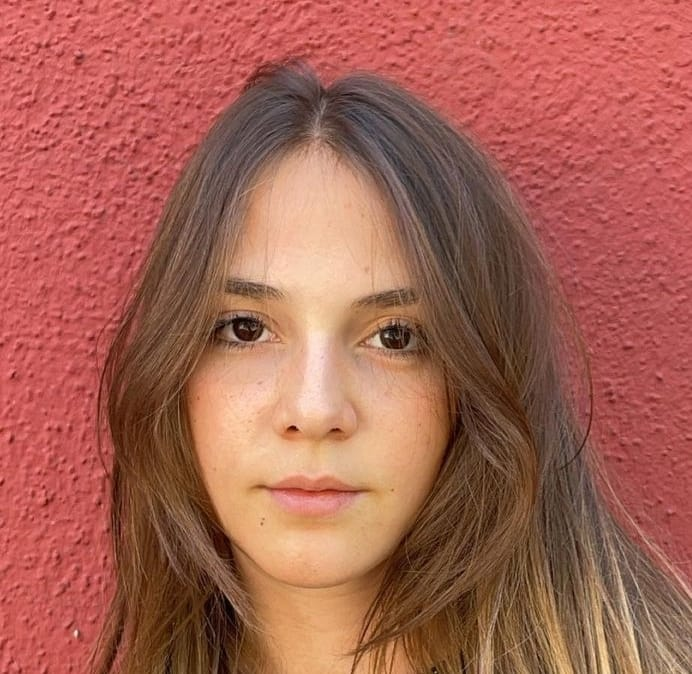

In [4]:
# loading input image
input = Image.open(input_filename).convert('RGB')
input

In [5]:
# adding segmentation filter
sf = segmentation_filter.SegmentationFilter(segmentation_model)
pl.add_filter(sf)

In [6]:
# executing pipeline: sf
img, masks = pl.execute(input, device)
img_segmented = color_processing.colorize_segmentation_masks(masks, segmentation_labels.labels)

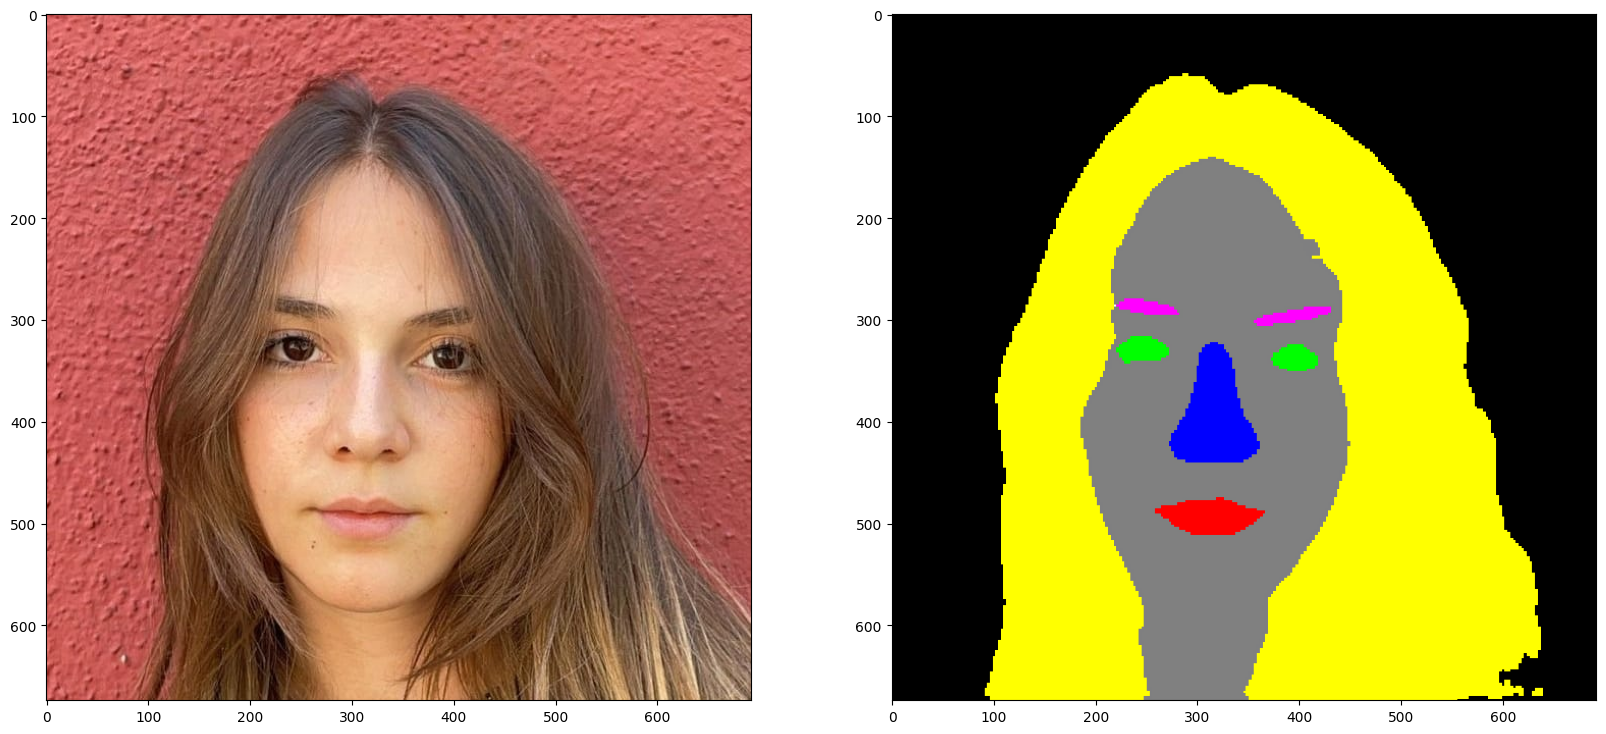

In [7]:
# showing output of pipeline: sf
plt.figure(figsize=(20, 12))
plt.subplot(1, 2, 1)
plt.imshow(utils.from_DHW_to_HWD(img))
plt.subplot(1, 2, 2)
plt.imshow(utils.from_DHW_to_HWD(img_segmented))

In [8]:
# adding user palette classification filter
upcf = user_palette_classification_filter.UserPaletteClassificationFilter(reference_palettes)
pl.add_filter(upcf)

Candidate: (227,173,134), Weighted Reconstruction Error: 30.85035045258113


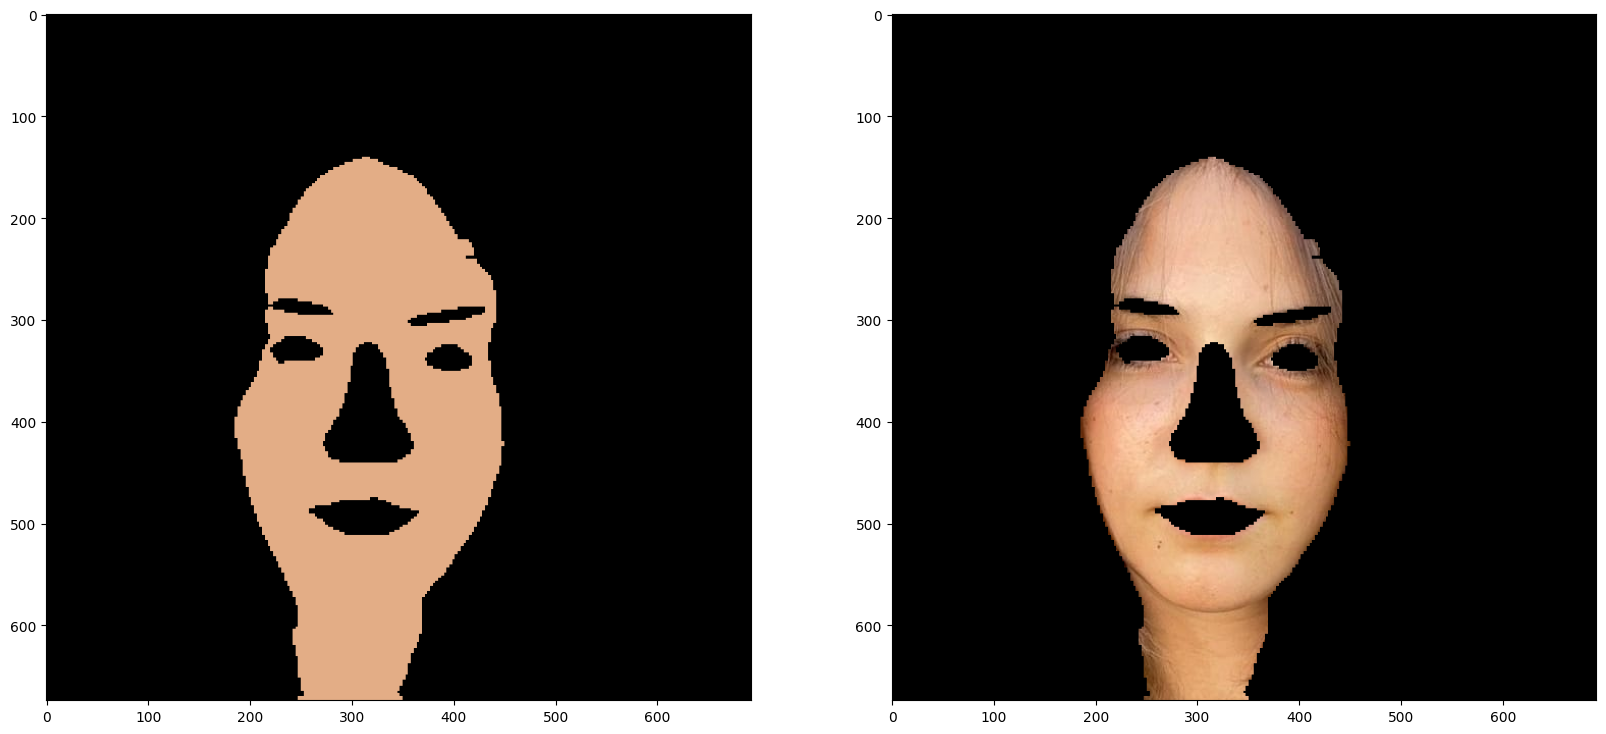

Candidate: (158,107,75), Weighted Reconstruction Error: 47.87120548319861


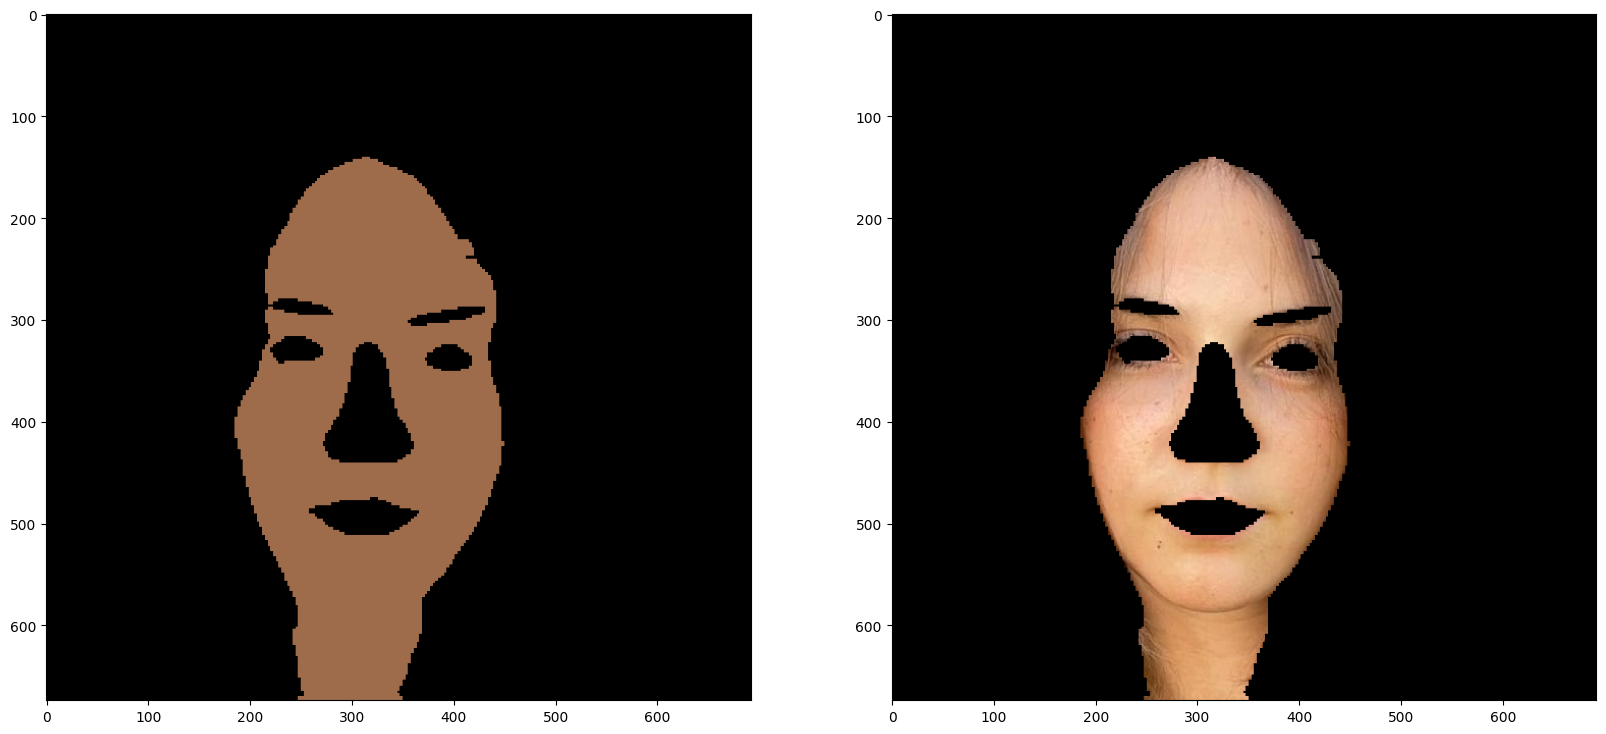

Candidate: (134,97,80), Weighted Reconstruction Error: 44.14926470758381


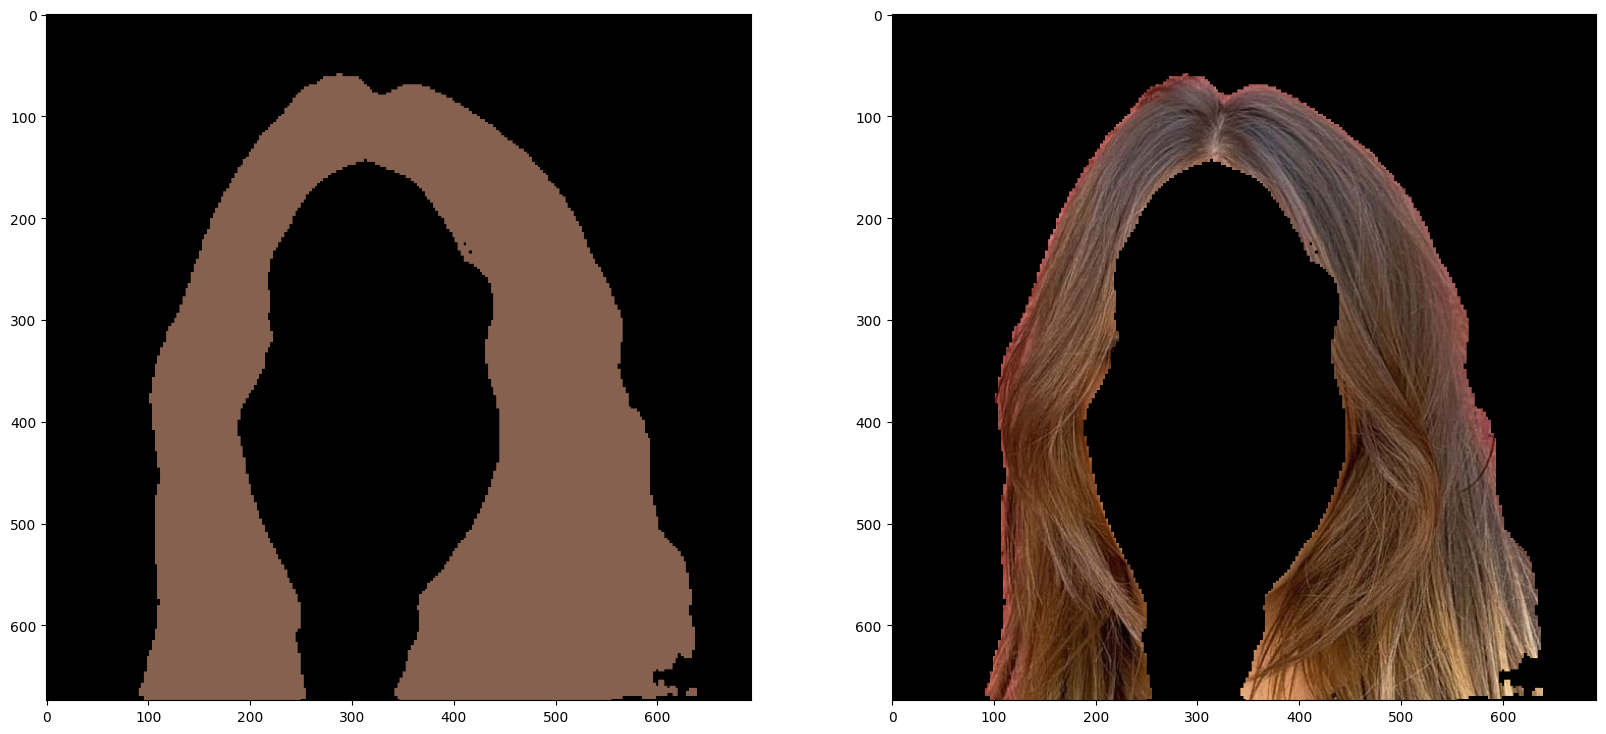

Candidate: (93,59,40), Weighted Reconstruction Error: 61.26283871139261


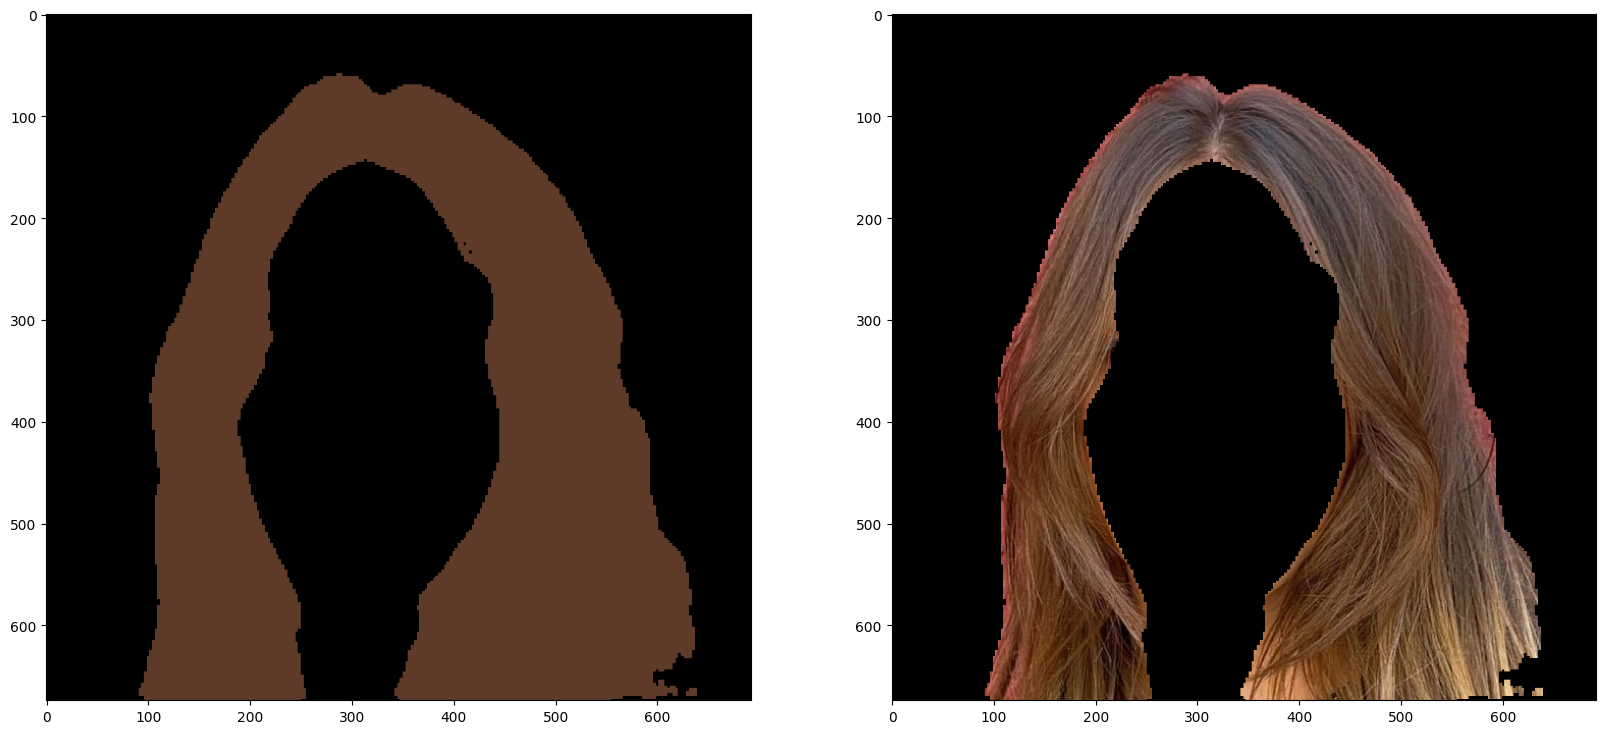

Candidate: (179,91,65), Weighted Reconstruction Error: 236.22645778873795


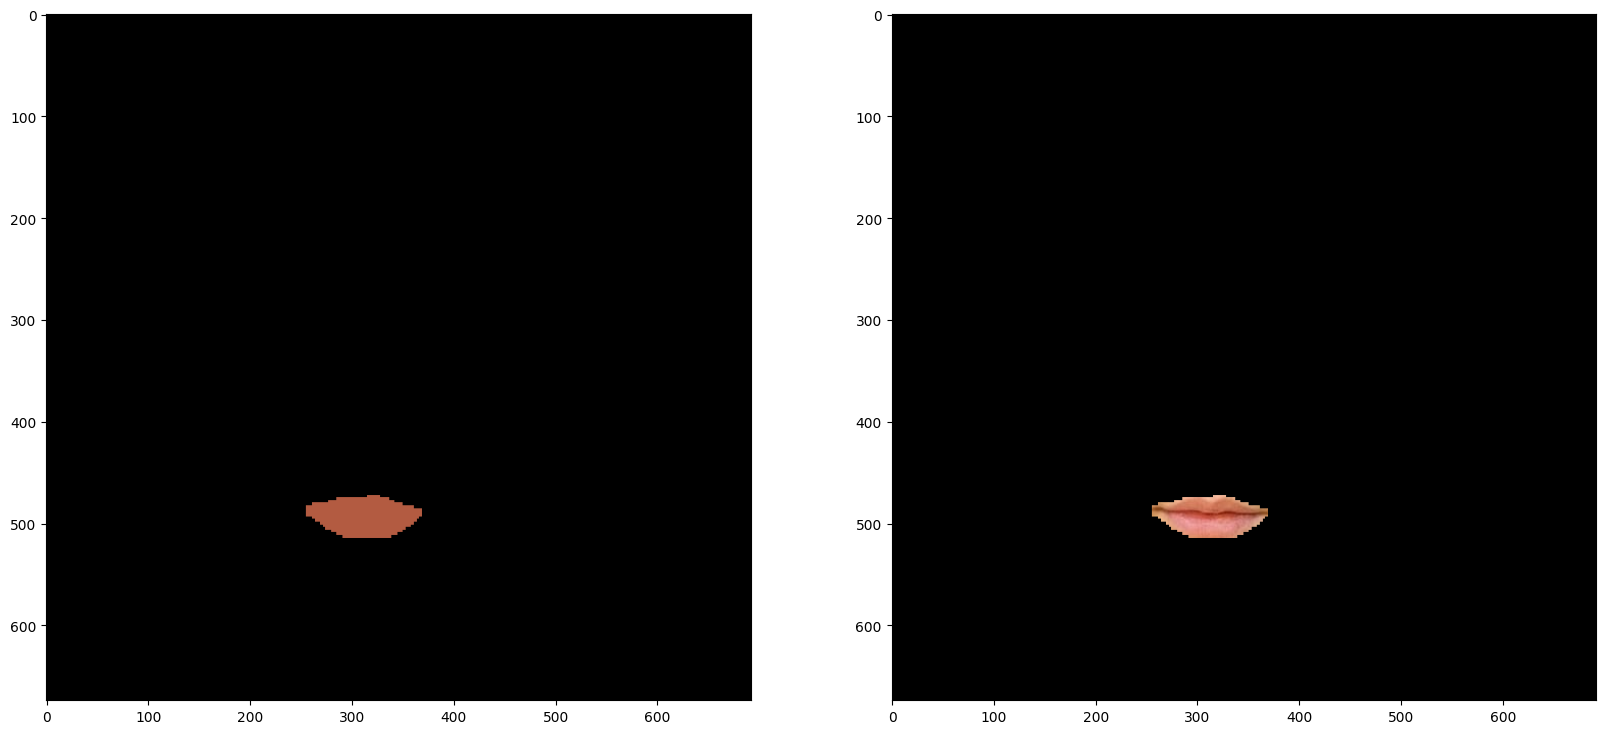

Candidate: (223,145,123), Weighted Reconstruction Error: 175.335704520097


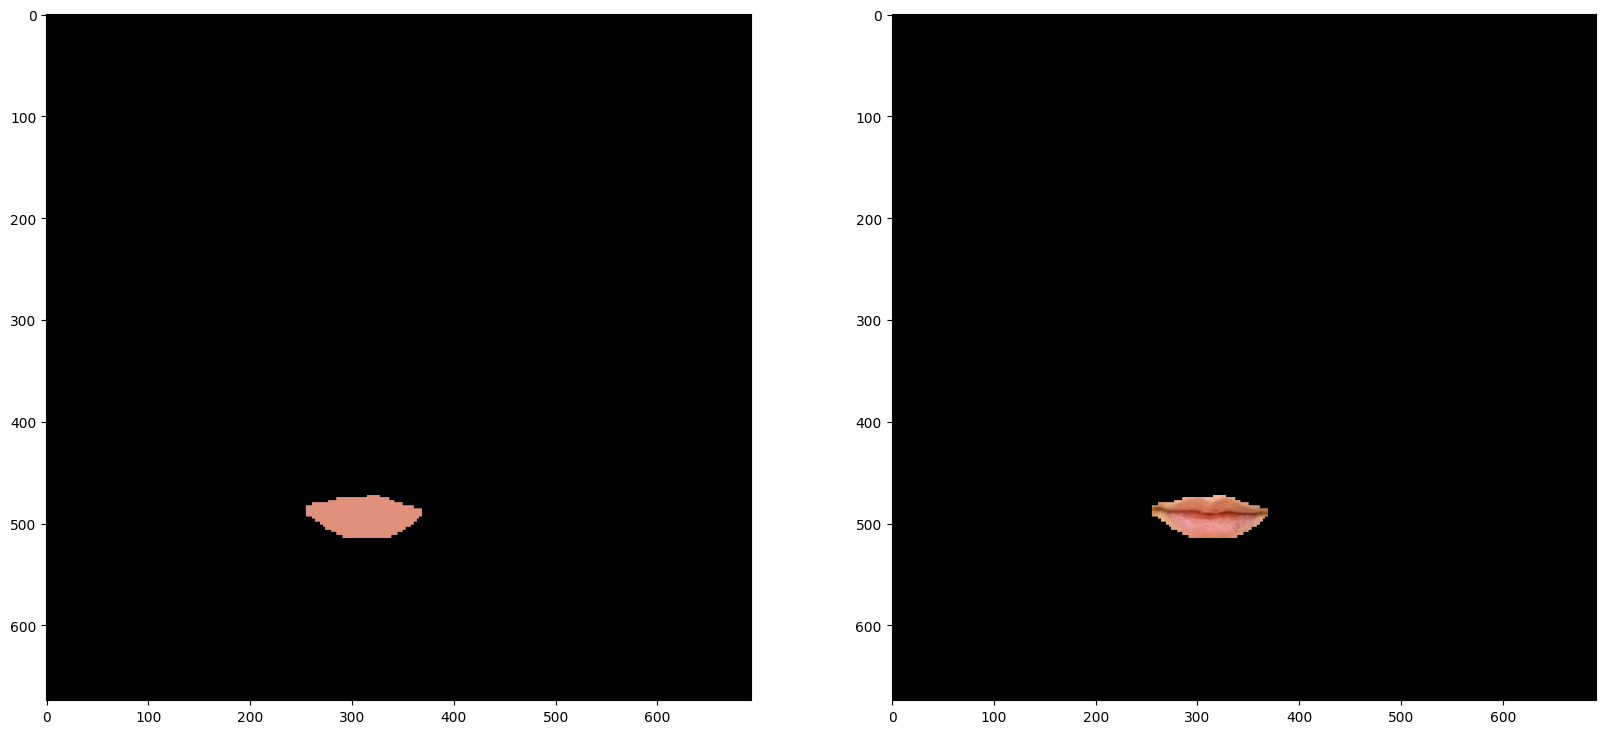

Candidate: (89,61,47), Weighted Reconstruction Error: 0.002033448446513439


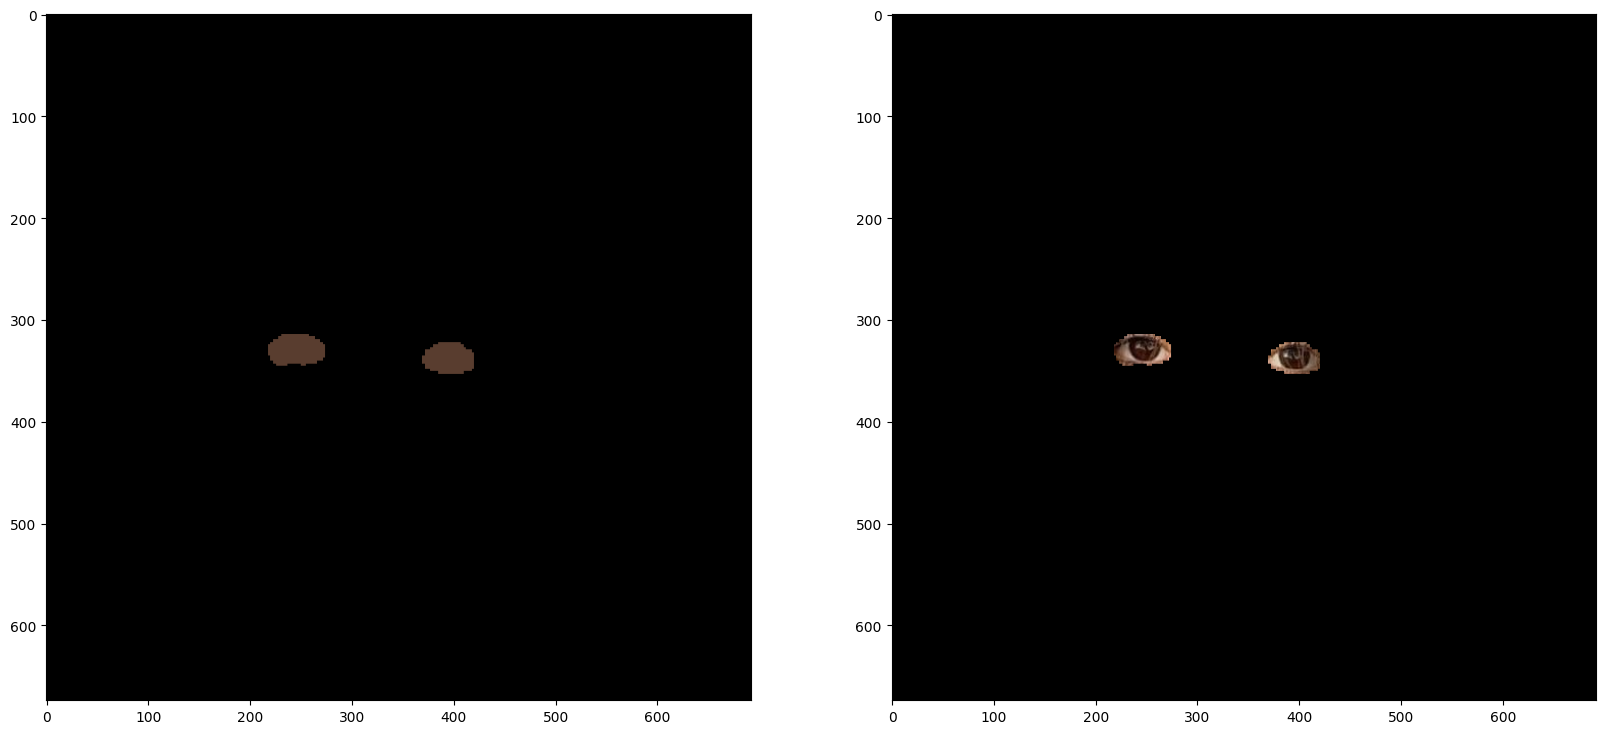

Candidate: (172,135,115), Weighted Reconstruction Error: 0.004000007879699573


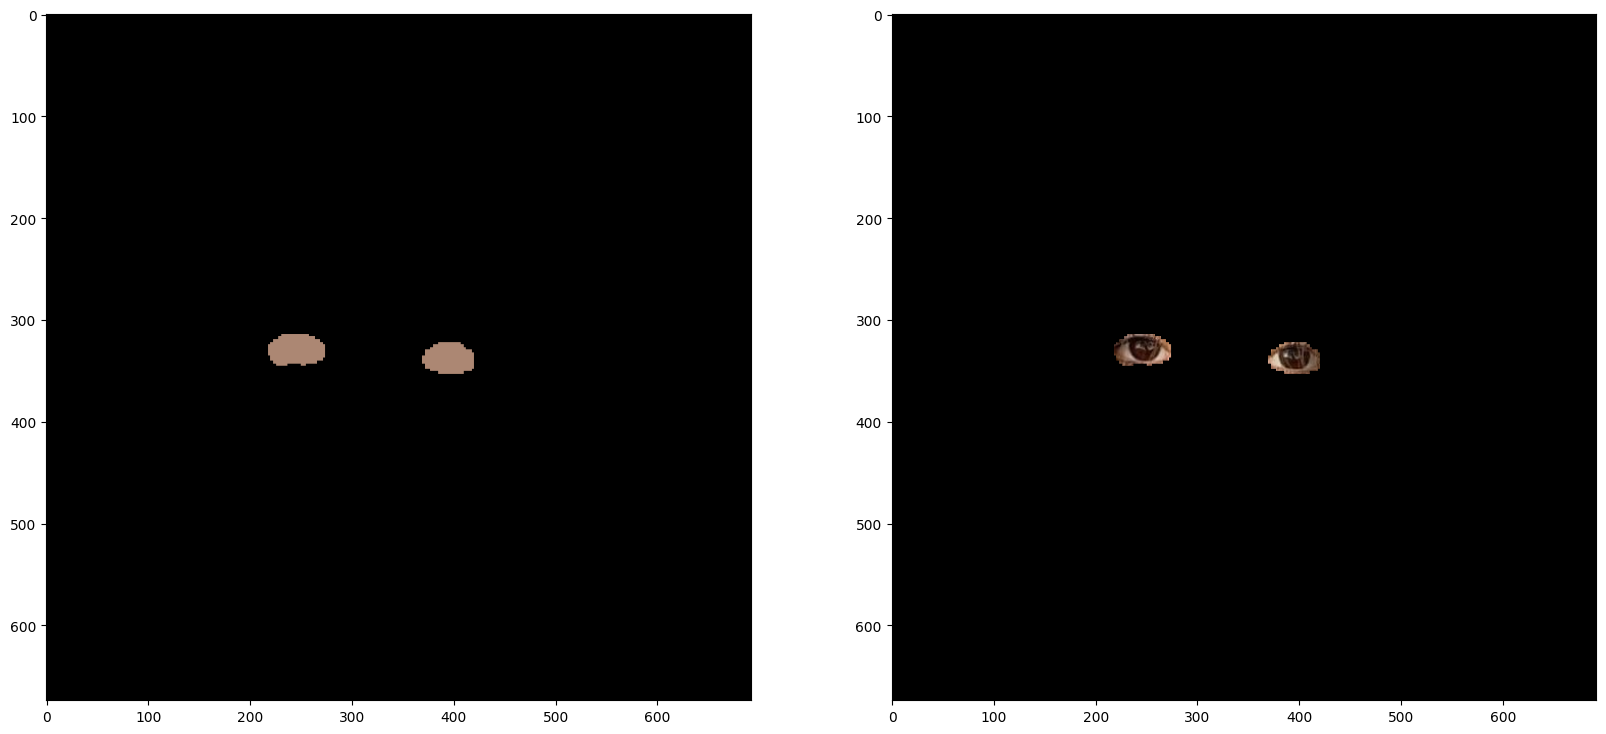

dominants


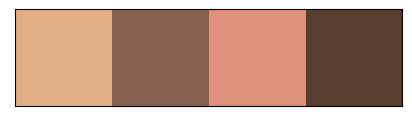

In [9]:
# executing pipeline: sf -> upcf
user_palette = pl.execute(input, device)

autumn


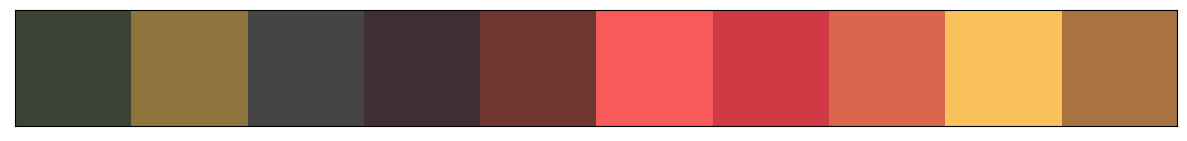

In [10]:
# # showing output of pipeline: sf -> upcf
print(user_palette.description())
user_palette.plot(tile_size=15)

In [11]:
# adding retrieval filter
rf = retrieval_filter.RetrievalFilter(cloth_dataset_path, palette_mappings_dict)
rf.set_query(query)
pl.add_filter(rf)

In [12]:
# executing pipeline: sf -> upcf -> rf
retrieved_clothes_paths = pl.execute(input, device)
n_retrieved_clothes = len(retrieved_clothes_paths)
print(f'Found {n_retrieved_clothes} clothes for query "{query}" and palette "{user_palette.description()}".')

100%|██████████| 169/169 [01:33<00:00,  1.80it/s]


Found 1371 clothes for query "dress" and palette "autumn".


Showing first 50 retrieved clothes.


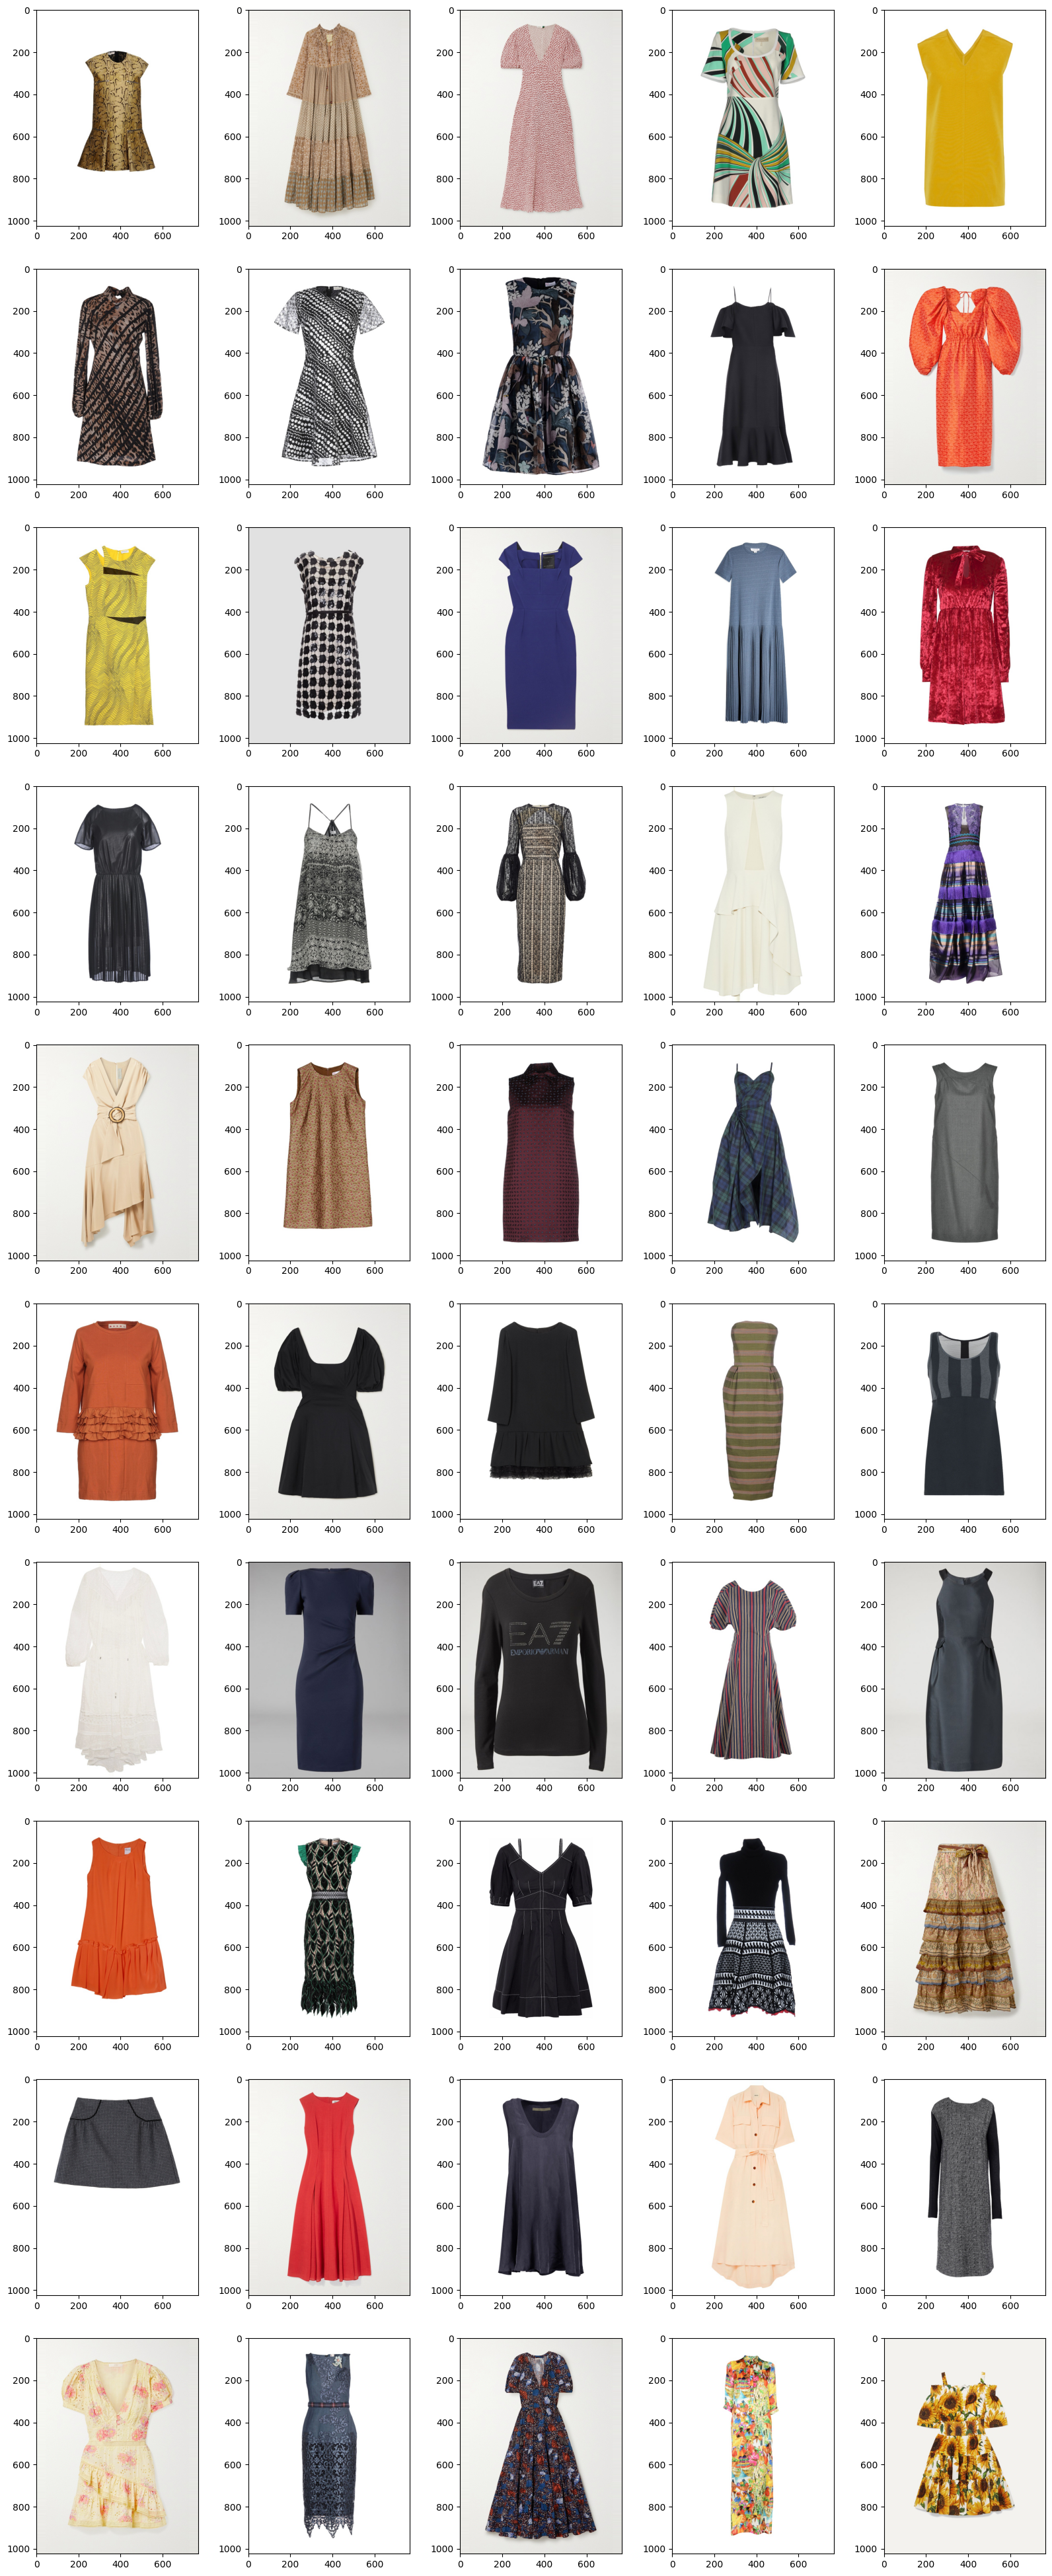

In [13]:
# plotting first n_plotted_retrieved_clothes outputs of pipeline: sf -> upcf -> rf
i = 1
n_columns = min(n_plotted_retrieved_clothes, 5)
n_rows = n_plotted_retrieved_clothes // n_columns
print(f'Showing first {n_plotted_retrieved_clothes} retrieved clothes.')
plt.figure(figsize=(20, 5 * n_rows))
for c in range(1, n_columns + 1):
    for r in range(1, n_rows + 1):
        plt.subplot(n_rows, n_columns, i)
        img = Image.open(retrieved_clothes_paths[i-1]).convert('RGB')
        plt.imshow(img)
        i += 1